# A/B Testing: Bayesian vs Frequentist Analysis
This notebook compares classical and Bayesian inference using simulated A/B test data.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. Simulamos los data
np.random.seed(42)
n = 100
true_theta = 0.62
data = np.random.binomial(1, true_theta, size=n)

# 2. Frequentist estimate
x = np.sum(data)
theta_hat = x / n

# 3. Intervalo de confidence 95%
confidence = 0.95
error = np.sqrt(theta_hat * (1 - theta_hat) / n)
z = stats.norm.ppf(1 - (1 - confidence) / 2)
ci_lower = theta_hat - z * error
ci_upper = theta_hat + z * error

print(f"Frequentist estimate: θ̂ = {theta_hat:.3f}")
print(f"Intervalo de confidence 95%: ({ci_lower:.3f}, {ci_upper:.3f})")


Frequentist estimate: θ̂ = 0.660
Intervalo de confidence 95%: (0.567, 0.753)


In [2]:
# Si no está instalado
#!pip install pymc --quiet


In [3]:
import numpy as np
np.random.seed(42)

# Parámetro real
true_theta = 0.62

# Simulación de 100 observationes (éxito = 1, fracaso = 0)
n = 100
data = np.random.binomial(1, true_theta, size=n)

# Conteo de éxitos
x = np.sum(data)
print(f"Éxitos observados: {x} de {n}")


Éxitos observados: 66 de 100


In [4]:
import scipy.stats as stats

# Estimación puntual
theta_hat = x / n

# Intervalo de confidence 95%
z = stats.norm.ppf(0.975)
error = np.sqrt(theta_hat * (1 - theta_hat) / n)
ci_lower = theta_hat - z * error
ci_upper = theta_hat + z * error

print(f"Frequentist estimate: θ̂ = {theta_hat:.3f}")
print(f"95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")


Frequentist estimate: θ̂ = 0.660
95% CI: (0.567, 0.753)


## Data Loading and Summary
We load the simulated conversion data and compute group-level conversion rates.

In [5]:
import pymc as pm
import arviz as az

with pm.Model() as bayesian_model:
    # Non-informative prior: Beta(1,1)
# Define prior distributions for Bayesian model
    theta = pm.Beta('theta', alpha=1, beta=1)

    # Likelihood: data binarios
    observation = pm.Bernoulli('obs', p=theta, observed=data)

    # Posterior sampling
# Sample from the posterior using MCMC
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)


Output()

In [6]:
az.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.66,0.046,0.566,0.75,0.001,0.001,1963.0,2692.0,1.0


<Axes: title={'center': 'theta'}>

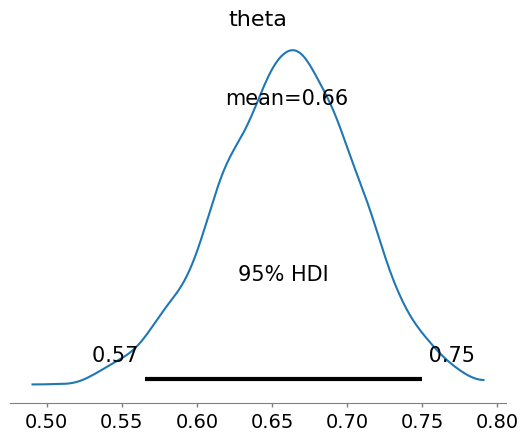

In [7]:
# Plot posterior distributions of conversion rates
az.plot_posterior(trace, var_names=['theta'], hdi_prob=0.95)


In [8]:
print(f"Frequentist estimate: θ̂ = {theta_hat:.3f} con 95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")

posterior_media = trace.posterior['theta'].mean().item()
# Access the HDI values directly from the az.hdi output
posterior_hdi = az.hdi(trace, hdi_prob=0.95)['theta'].values

print(f"Media bayesiana: {posterior_media:.3f}")
print(f"Intervalo de credibilidad 95%: ({posterior_hdi[0]:.3f}, {posterior_hdi[1]:.3f})")

Frequentist estimate: θ̂ = 0.660 con 95% CI: (0.567, 0.753)
Media bayesiana: 0.660
Intervalo de credibilidad 95%: (0.566, 0.750)


## Frequentist Analysis
We compute confidence intervals and perform hypothesis testing using frequentist methods.

# Haciendo la comparación pero con procesos de conteo

In [9]:
np.random.seed(66)

# Parámetro real: tasa de ocurrencia
lambda_real = 4.2  # por ejemplo, 4.2 llamadas por hora
n = 30  # observationes (100 horas)

# Simulación de conteos
data = np.random.poisson(lam=lambda_real, size=n)

# Estadística descriptiva
print(f"Número total de eventos: {np.sum(data)}")
print(f"Media muestral: {np.mean(data):.2f}")


Número total de eventos: 109
Media muestral: 3.63


In [10]:
# Estimación puntual de lambda
lambda_hat = np.mean(data)

# 95% CI usando normalidad asintótica
error = np.sqrt(lambda_hat / n)
z = stats.norm.ppf(0.975)
ci_lower = lambda_hat - z * error
ci_upper = lambda_hat + z * error

print(f"Frequentist estimate: λ̂ = {lambda_hat:.3f}")
print(f"95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")


Frequentist estimate: λ̂ = 3.633
95% CI: (2.951, 4.315)


In [11]:
with pm.Model() as modelo_poisson:
    # Priori conjugada para lambda (tasa): Gamma(1, 1)
    lam = pm.Gamma('lambda', alpha=1, beta=1)

    # Likelihood
    observation = pm.Poisson('obs', mu=lam, observed=data)

    # Muestreo
# Sample from the posterior using MCMC
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Output()

In [12]:
az.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,3.547,0.339,2.87,4.171,0.009,0.005,1535.0,2603.0,1.0


<Axes: title={'center': 'lambda'}>

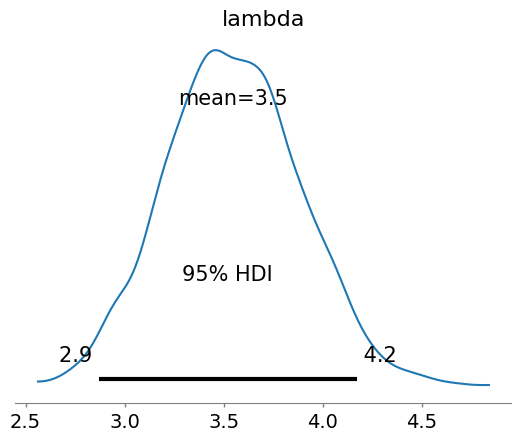

In [13]:
# Plot posterior distributions of conversion rates
az.plot_posterior(trace, var_names=['lambda'], hdi_prob=0.95)


In [14]:
posterior_media = trace.posterior['lambda'].mean().item()
# Access the HDI values directly from the az.hdi output
posterior_hdi = az.hdi(trace, hdi_prob=0.95)['lambda'].values

print(f"Frecuentista λ̂ = {lambda_hat:.3f}, 95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")
print(f"Bayesiano λ ≈ {posterior_media:.3f}, intervalo de credibilidad: ({posterior_hdi[0]:.3f}, {posterior_hdi[1]:.3f})")

Frecuentista λ̂ = 3.633, 95% CI: (2.951, 4.315)
Bayesiano λ ≈ 3.547, intervalo de credibilidad: (2.870, 4.171)


## Bayesian Analysis with PyMC
We define a Bayesian model with Beta priors and sample from the posterior distribution.

Ahora con una priori más informativa

In [15]:
with pm.Model() as modelo_poisson_informativo:
    # Prior informativa centrada en 5, desviación 1
    lam = pm.Gamma('lambda', alpha=25, beta=5)

    observation = pm.Poisson('obs', mu=lam, observed=data)

# Sample from the posterior using MCMC
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)


Output()

<Axes: title={'center': 'lambda'}>

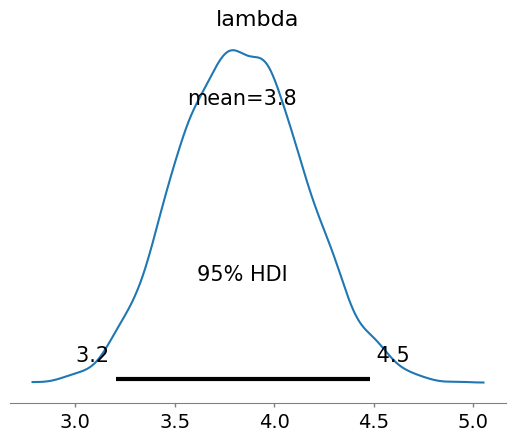

In [16]:
# Plot posterior distributions of conversion rates
az.plot_posterior(trace, var_names=['lambda'], hdi_prob=0.95)


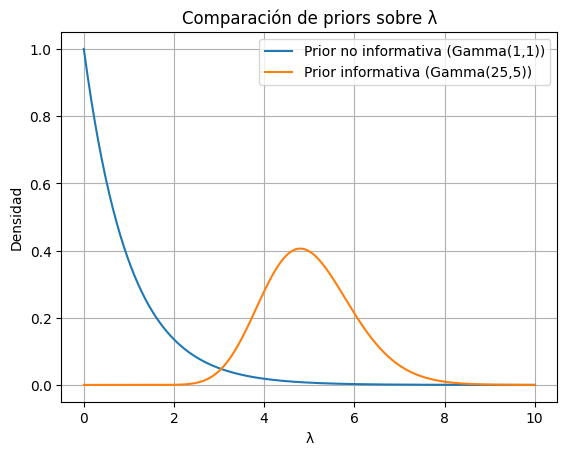

In [17]:
import matplotlib.pyplot as plt
import scipy.stats as stats
x_vals = np.linspace(0, 10, 500)

plt.plot(x_vals, stats.gamma.pdf(x_vals, a=1, scale=1), label='Prior no informativa (Gamma(1,1))')
plt.plot(x_vals, stats.gamma.pdf(x_vals, a=25, scale=1/5), label='Prior informativa (Gamma(25,5))')
plt.title("Comparación de priors sobre λ")
plt.xlabel("λ")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.show()


### Generate Data

## Posterior Analysis
We visualize the posterior distributions and compute the probability that variant B is better than A.

In [18]:
import pandas as pd
import numpy as np

# Simulate A/B test
np.random.seed(42)
n_A, n_B = 500, 500
p_A, p_B = 0.11, 0.17  # true conversion rates

data = pd.DataFrame({
    'group': ['A'] * n_A + ['B'] * n_B,
    'converted': np.concatenate([
        np.random.binomial(1, p_A, n_A),
        np.random.binomial(1, p_B, n_B)
    ])
})

# Save as CSV
data.to_csv('conversions.csv', index=False)


Comparative A/B Testing using both approaches

###  A/B Testing: Bayesian vs. Frequentist Inference

#### Section 1: Data Overview and Frequentist Approach

We begin by analyzing conversion rates from a simulated A/B test. Group A is the control group, and Group B is the variant. We'll use classical (frequentist) methods to estimate conversion rates and construct confidence intervals.


## Decision Analysis: Expected Utility
Using the posterior, we calculate the expected utility of switching to B based on cost-benefit assumptions.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Compute frequentist confidence intervals
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Load the dataset
# Load the dataset from CSV file
data = pd.read_csv('conversions.csv')

# Basic overview
data.head()


,group,converted
0,A,0
1,A,1
2,A,0
3,A,0
4,A,0


### Conversion Rate Summary

We calculate the observed conversion rates for each group and visualize the differences.


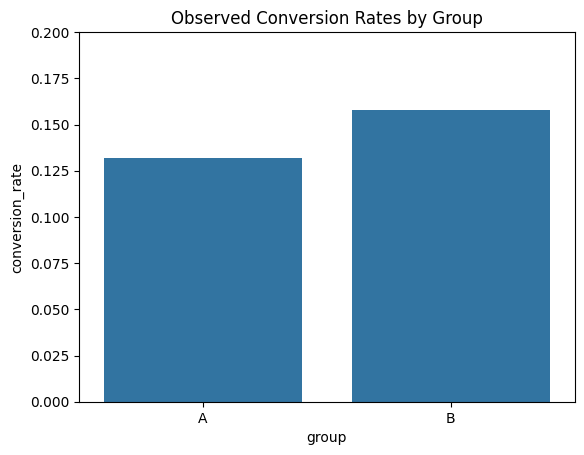

,group,conversion_rate,conversions,total
0,A,0.132,66,500
1,B,0.158,79,500


In [20]:
# Group summary
# Summarize conversion data by group
summary = data.groupby('group')['converted'].agg(['mean', 'sum', 'count']).reset_index()
summary.columns = ['group', 'conversion_rate', 'conversions', 'total']

# Bar plot
# Plot observed conversion rates by group
sns.barplot(x='group', y='conversion_rate', data=summary)
plt.title('Observed Conversion Rates by Group')
plt.ylim(0, 0.2)
plt.show()

summary


## Frequentist Confidence Intervals

We construct 95% confidence intervals for the conversion rate of each group using the normal approximation method.


In [21]:
conf_ints = []

for i, row in summary.iterrows():
# Compute frequentist confidence intervals
    lower, upper = proportion_confint(
        count=row['conversions'],
        nobs=row['total'],
        alpha=0.05,
        method='normal'
    )
    conf_ints.append((row['group'], lower, upper))

conf_df = pd.DataFrame(conf_ints, columns=['group', 'lower_ci', 'upper_ci'])
pd.merge(summary, conf_df, on='group')


,group,conversion_rate,conversions,total,lower_ci,upper_ci
0,A,0.132,66,500,0.102331,0.161669
1,B,0.158,79,500,0.126030,0.189970


## Hypothesis Testing: Are Conversion Rates Different?

We conduct a two-proportion z-test to test the null hypothesis:

**H₀**: Conversion rates are equal (p_A = p_B)  
**H₁**: Conversion rates are different (p_A ≠ p_B)


In [22]:
count = summary['conversions'].values
nobs = summary['total'].values

# Perform two-proportion z-test
z_stat, p_value = proportions_ztest(count, nobs)
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.4f}")


Z-statistic: -1.168
P-value: 0.2430


## Bayesian Inference with PyMC

We now adopt a Bayesian approach to estimate conversion probabilities.  
We assume each group's conversion rate follows a Beta distribution, the conjugate prior of the Bernoulli likelihood.


In [23]:
# If running in Colab or local for the first time:
# !pip install pymc arviz --quiet

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


In [24]:
# Extract data counts
conversions_A = summary.loc[summary['group'] == 'A', 'conversions'].values[0]
total_A = summary.loc[summary['group'] == 'A', 'total'].values[0]

conversions_B = summary.loc[summary['group'] == 'B', 'conversions'].values[0]
total_B = summary.loc[summary['group'] == 'B', 'total'].values[0]


In [25]:
with pm.Model() as model:
    # Priors: Beta(1,1) is uniform prior (non-informative)
# Define prior distributions for Bayesian model
    p_A = pm.Beta('p_A', alpha=1, beta=1)
# Define prior distributions for Bayesian model
    p_B = pm.Beta('p_B', alpha=1, beta=1)

    # Likelihood
# Define likelihood using Binomial distribution
    obs_A = pm.Binomial('obs_A', n=total_A, p=p_A, observed=conversions_A)
# Define likelihood using Binomial distribution
    obs_B = pm.Binomial('obs_B', n=total_B, p=p_B, observed=conversions_B)

    # Posterior sampling
# Sample from the posterior using MCMC
    trace = pm.sample(2000, return_inferencedata=True, random_seed=42)


Output()

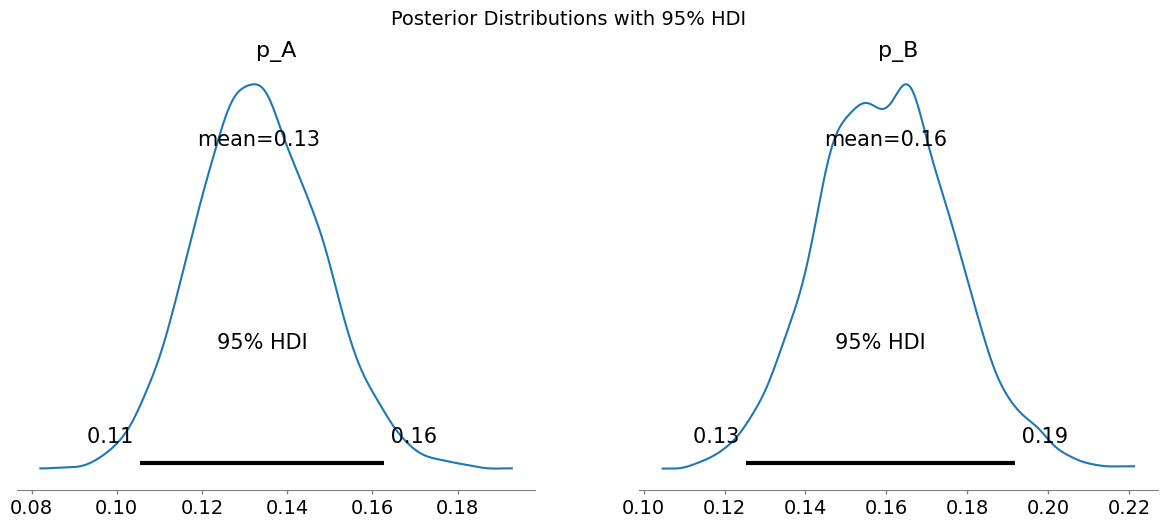

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_A,0.133,0.015,0.105,0.163,0.0,0.0,3730.0,2844.0,1.0
p_B,0.160,0.017,0.125,0.192,0.0,0.0,3843.0,2711.0,1.0


In [26]:
# Plot posterior distributions of conversion rates
az.plot_posterior(trace, var_names=['p_A', 'p_B'], hdi_prob=0.95)
plt.suptitle("Posterior Distributions with 95% HDI", fontsize=14)
plt.show()

az.summary(trace, var_names=['p_A', 'p_B'], hdi_prob=0.95)


## Posterior Probability Comparison

We now compute the probability that the conversion rate in group B is greater than in group A, based on the posterior samples.


In [27]:
p_A_samples = trace.posterior['p_A'].stack(draws=("chain", "draw")).values
p_B_samples = trace.posterior['p_B'].stack(draws=("chain", "draw")).values

# Calculate posterior probability that B is better than A
prob_B_superior = (p_B_samples > p_A_samples).mean()
print(f"Posterior probability that p_B > p_A: {prob_B_superior:.3f}")


Posterior probability that p_B > p_A: 0.884


## Credible Intervals vs. Confidence Intervals

The 95% Highest Density Interval (HDI) from the Bayesian posterior tells us the range in which the conversion rate lies with 95% probability.

Unlike frequentist confidence intervals, HDIs can be interpreted probabilistically:
> "There's a 95% chance the true value lies in this interval."

We now compare the two approaches graphically.


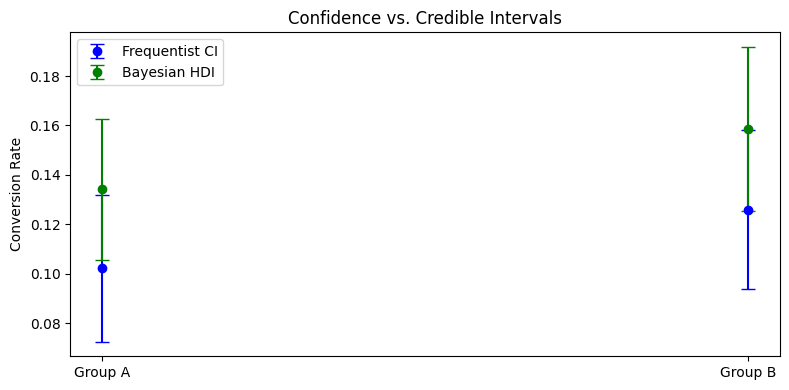

In [28]:
# Compute frequentist confidence intervals
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import arviz as az
import os

# Frequentist CI
# Compute frequentist confidence intervals
ci_A = proportion_confint(count=conversions_A, nobs=total_A, method='normal')
# Compute frequentist confidence intervals
ci_B = proportion_confint(count=conversions_B, nobs=total_B, method='normal')

# Bayesian HDI
# Access the HDI values directly from the az.hdi output for each variable
hdi_A = az.hdi(trace, var_names=['p_A'], hdi_prob=0.95)['p_A'].values
hdi_B = az.hdi(trace, var_names=['p_B'], hdi_prob=0.95)['p_B'].values

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
labels = ['Group A', 'Group B']

# Plot CIs
ax.errorbar([0, 1], [ci_A[0], ci_B[0]], yerr=[(ci_A[1]-ci_A[0])/2, (ci_B[1]-ci_B[0])/2],
            fmt='o', label='Frequentist CI', capsize=5, color='blue')

# Plot HDIs
ax.errorbar([0, 1], [hdi_A.mean(), hdi_B.mean()],
            yerr=[(hdi_A[1]-hdi_A[0])/2, (hdi_B[1]-hdi_B[0])/2], # Corrected yerr calculation
            fmt='o', label='Bayesian HDI', capsize=5, color='green')

ax.set_xticks([0, 1])
ax.set_xticklabels(labels)
ax.set_ylabel('Conversion Rate')
ax.set_title('Confidence vs. Credible Intervals')
ax.legend()
plt.tight_layout()

# Create the directory if it doesn't exist
output_dir = '../figures/'
os.makedirs(output_dir, exist_ok=True)

# Save plot comparing confidence and credible intervals
plt.savefig(os.path.join(output_dir, 'credible_vs_confidence.png'))
plt.show()

## Posterior Distribution of Difference: \( p_B - p_A \)

We compute the difference between sampled values of \( p_B \) and \( p_A \) to analyze the magnitude of the effect. This is useful for understanding not just *if* B is better than A, but *how much better*.


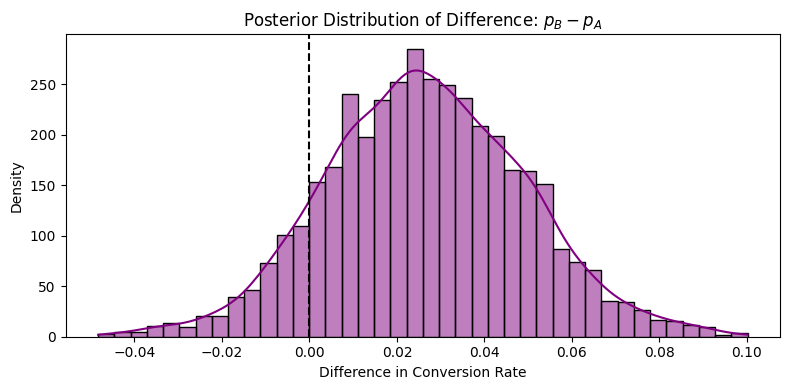

Probability that p_B > p_A: 0.884
Mean difference: 0.0266
95% HDI: [-0.0176, 0.0724]


In [29]:
# Compute the posterior difference
diff = p_B_samples - p_A_samples

# Plot
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, color='purple', bins=40)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Posterior Distribution of Difference: $p_B - p_A$')
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# Summary stats
prob_diff_gt_zero = (diff > 0).mean()
print(f"Probability that p_B > p_A: {prob_diff_gt_zero:.3f}")
print(f"Mean difference: {diff.mean():.4f}")
print(f"95% HDI: [{np.percentile(diff, 2.5):.4f}, {np.percentile(diff, 97.5):.4f}]")


## Conclusion: Bayesian vs. Frequentist Inference with Moderate Differences

In this scenario ($ p_A = 0.11 $, $ p_B = 0.17 $), the two approaches lead to nuanced interpretations:

- The **frequentist z-test** yields a p-value of approximately 0.24, which is not low enough to reject the null hypothesis of equal conversion rates.
- The **Bayesian analysis** produces a posterior probability \( P(p_B > p_A) \approx 0.884 \), indicating a high likelihood that Group B outperforms Group A — though not conclusively.

### Interpretation

The Bayesian approach provides a probabilistic estimate of belief in an effect, showing that there is nearly an 88% chance that Group B is better. However, the frequentist approach does not provide strong enough evidence to reject the null, likely due to variability or sample size limitations.

### Practical Implication

This is a borderline case. If action requires high certainty (e.g., 95%+), the evidence is insufficient. But if a moderate probability of improvement justifies implementation or further testing, Bayesian inference provides a compelling argument to explore Group B further.

### Reflection

This example illustrates how Bayesian inference can detect patterns suggestive of a true effect even when frequentist methods remain inconclusive — especially useful in exploratory or decision-driven settings.


### Decision Theory : Bayesian Expected Utility vs. Frequentist p-Value

In classical statistics, a common decision rule is to reject the null hypothesis when the **p-value** is below a threshold (typically 0.05). In our analysis, the frequentist test returned:

- **p-value ≈ 0.24** → this does **not** meet the threshold to reject the null hypothesis.
- Therefore, under frequentist rules, **no action** would be taken.

However, Bayesian inference allows a more nuanced approach by incorporating **both uncertainty and utility**. Instead of asking:

> "Is the result statistically significant?"

we ask:

> "Given the evidence, what is the expected gain or loss from acting?"

Assuming the following utility model:

- Switching to variant B and being correct → **+100 units**
- Switching and being wrong → **–50 units**
- Staying with A → **0 units**

We compute the **expected utility of switching to B**:

$$
EU(\text{switch}) = P(p_B > p_A) \cdot 100 + P(p_B \leq p_A) \cdot (-50)
$$

With a posterior probability $ P(p_B > p_A) ≈ 0.884 $, the expected utility remains **positive**, which would justify switching to B.

---


| Criterion               | Result       | Action                                   |
|------------------------|--------------|------------------------------------------|
| Frequentist p-value    | 0.24         | Do not reject null → **no action**       |
| Bayesian posterior     | 0.884        | High probability of improvement          |
| Expected Utility       | Positive     | **Switch to B justified by net gain**    |



---



While the frequentist framework suggests inaction, the Bayesian approach — informed by the probability of success and the cost-benefit structure — supports a rational decision to adopt variant B. This illustrates how **Bayesian methods can guide action under uncertainty**, even when p-values are not significant.
